Figure saved to: ../results/figures\fig6_dual_mode_heatmap_grouped.pdf
If the plot is still blank, please verify that the 'Theta' extraction matched the columns in your CSV.


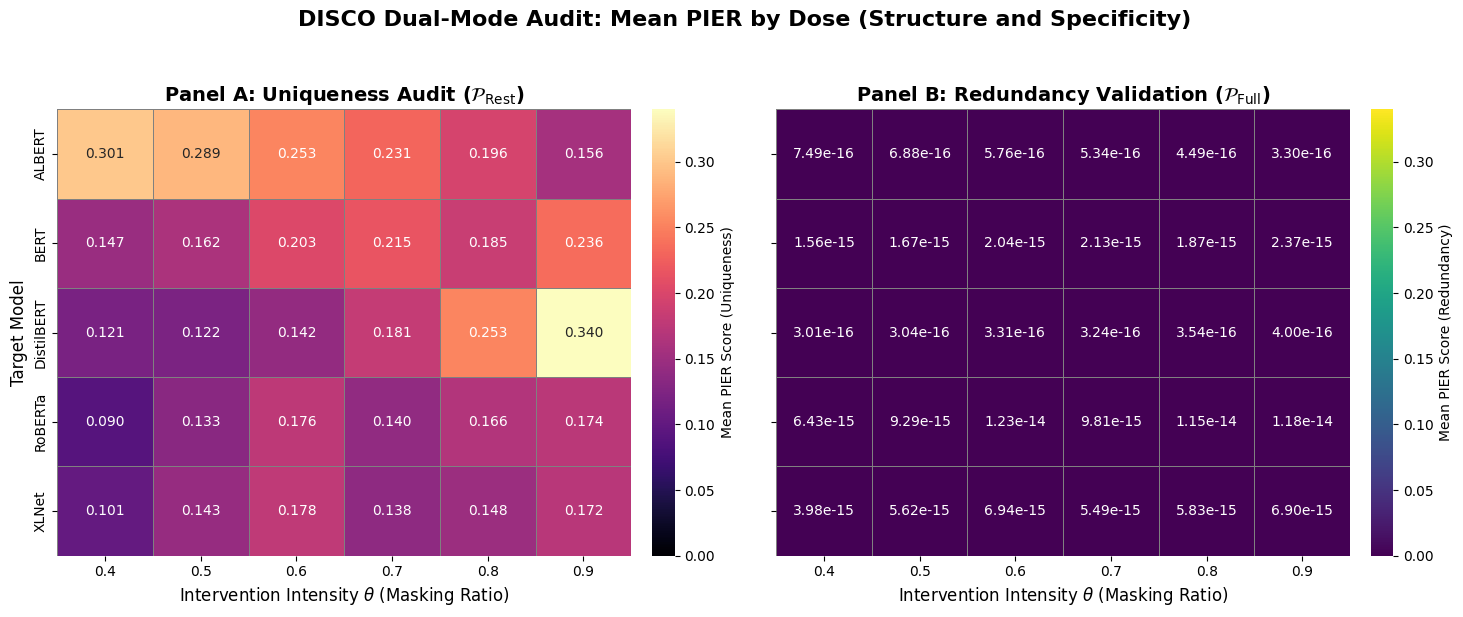

In [1]:
# notebooks/05_residual_heatmap_grouped.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load Data
DATA_PATH = "../results/tables/exp5_dual_mode_residuals.csv"
FIG_PATH = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}. Please run experiments/exp5_dual_mode_audit.py first.")
    exit()
else:
    df_raw = pd.read_csv(DATA_PATH)

# --- Data Transformation and Aggregation ---

# 1. FIX: Robust Extraction of Numeric Theta from string 'Sample X $\theta=0.40$'
df_processed = df_raw.copy()
# Regex searches for the float number (e.g., 0.40) immediately following '='
# This is the most reliable way given the provided data structure.
df_processed['Theta'] = df_processed['Eval_Point'].str.extract(r'=([0-9\.]+)', expand=False).astype(float)
df_processed = df_processed.drop(columns=['Eval_Point'])


# 2. Convert to Long Format (Melt)
residual_cols = [col for col in df_processed.columns if '_R' in col]

df_melted = df_processed.melt(
    id_vars=['Theta'],
    value_vars=residual_cols,
    var_name='Target_Mode',
    value_name='Residual_Value'
)

# 3. Separate Target Name and Audit Mode Type
# Target_Mode is e.g., 'BERT_Uniqueness_R'
df_melted['Target_Name'] = df_melted['Target_Mode'].apply(lambda x: x.split('_')[0])
# Mode_Type becomes 'Uniqueness_R' or 'Redundancy_R'
df_melted['Mode_Type'] = df_melted['Target_Mode'].apply(lambda x: '_'.join(x.split('_')[1:])) 


# 4. Aggregate by (Theta, Target_Name, Mode_Type) to get Mean PIER (The core grouping step)
df_grouped = df_melted.groupby(['Theta', 'Target_Name', 'Mode_Type'])['Residual_Value'].mean().reset_index()


# 5. Pivot into Heatmap Matrices (Filtered by correct Mode_Type)
df_unique_pivot = df_grouped[df_grouped['Mode_Type'] == 'Uniqueness_R'].pivot(
    index='Target_Name', 
    columns='Theta', 
    values='Residual_Value'
).rename_axis(None, axis=1)

df_redundancy_pivot = df_grouped[df_grouped['Mode_Type'] == 'Redundancy_R'].pivot(
    index='Target_Name', 
    columns='Theta', 
    values='Residual_Value'
).rename_axis(None, axis=1)


# 6. Apply Sorting for Better Visualization
sort_order = ["RoBERTa", "XLNet", "ALBERT", "DistilBERT", "BERT"]
sort_indices = df_unique_pivot.index.intersection(sort_order)
df_unique_pivot = df_unique_pivot.loc[sort_indices]
df_redundancy_pivot = df_redundancy_pivot.loc[sort_indices]


# --- Visualization: Side-by-Side Heatmaps ---

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Define common scale and fix the ValueError calculation
v_max = max(np.nanmax(df_unique_pivot.values) if not df_unique_pivot.empty else 0.0, 0.25)


# 1. Plot Unique Audit (Sensitivity)
sns.heatmap(
    df_unique_pivot, 
    ax=axes[0], 
    cmap="magma", 
    annot=True,
    fmt=".3f", 
    vmin=0, 
    vmax=v_max, 
    cbar_kws={'label': 'Mean PIER Score (Uniqueness)', 'pad': 0.03},
    linewidths=0.5,
    linecolor='gray'
)
axes[0].set_title(r'Panel A: Uniqueness Audit ($\mathcal{P}_{\text{Rest}}$)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Target Model', fontsize=12)
axes[0].set_xlabel(r'Intervention Intensity $\theta$ (Masking Ratio)', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)

# 2. Plot Redundancy Validation (Specificity)
sns.heatmap(
    df_redundancy_pivot, 
    ax=axes[1], 
    cmap="viridis", 
    annot=True,
    fmt=".2e", # Exponential format clearly shows values near zero
    vmin=0, 
    vmax=v_max, 
    cbar_kws={'label': 'Mean PIER Score (Redundancy)', 'pad': 0.03},
    linewidths=0.5,
    linecolor='gray'
)
axes[1].set_title(r'Panel B: Redundancy Validation ($\mathcal{P}_{\text{Full}}$)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xlabel(r'Intervention Intensity $\theta$ (Masking Ratio)', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)

plt.suptitle("DISCO Dual-Mode Audit: Mean PIER by Dose (Structure and Specificity)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save
save_path = os.path.join(FIG_PATH, "fig6_dual_mode_heatmap_grouped.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")
print("If the plot is still blank, please verify that the 'Theta' extraction matched the columns in your CSV.")

plt.show()